pip install tensorflow  


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import imageio
import math
import IPython.display
import PIL

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [27]:
def imshow(data):
    data = np.clip(data, 0.0, 255.0).astype(np.uint8)
    pil_img = PIL.Image.fromarray(data, 'RGB')
    display(pil_img)
    return pil_img

In [3]:
patch_size = 64
mini_batch_size = 5
percent_used_for_validation = 0.1
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [4]:
def make_3_channels(image):
    if image.ndim == 2: image = np.dstack((image, image, image))
    image = image[:,:,:3]
    return image

def preprocess_color(color, albedo, epsilon=0.00316):
    return color.astype(np.float32) / (albedo + epsilon)

def postprocess_color(color, albedo, epsilon=0.00316):
    return color * (albedo + epsilon)

def preprocess_color_variance(variance, albedo, epsilon=0.00316):
    return variance / (albedo + epsilon)**2

def calculate_gradient(image):
    y, x, c = image.shape
    dx = image[:, 1:, :] - image[:, :x-1, :]
    dy = image[1:, :, :] - image[:y-1, :, :]
    dx = np.append(dx, np.zeros([y, 1, c]), axis=1)
    dy = np.append(dy, np.zeros([1, x, c]), axis=0)
    grad = np.dstack((dx, dy))
    return grad

def load_highspp(folder_path):
    albedo = make_3_channels(imageio.imread(folder_path + "/albedo.png").astype(np.float32))
    color = make_3_channels(imageio.imread(folder_path + "/color.png").astype(np.float32))
    # color = preprocess_color(color, albedo)
    return color

def load_lowspp(folder_path):
    print("loading " + folder_path)

    # albedo buffers
    albedo = make_3_channels(imageio.imread(folder_path + "/albedo.png").astype(np.float32))
    # albedo_variance = make_3_channels(imageio.imread(folder_path + "/albedoVariance.png").astype(np.float32))
    # albedo_gradient = calculate_gradient(albedo)

    # color buffers
    color = make_3_channels(imageio.imread(folder_path + "/color.png").astype(np.float32))
    # color = preprocess_color(color, albedo)
    color_variance = make_3_channels(imageio.imread(folder_path + "/colorVariance.png").astype(np.float32))
    # color_variance = preprocess_color_variance(color_variance, albedo)
    color_gradient = calculate_gradient(color)

    # depth buffers
    depth = imageio.imread(folder_path + "/depth.png").astype(np.float32)
    depth = depth.reshape((depth.shape[0], depth.shape[1], 1))
    # depth_variance = imageio.imread(folder_path + "/depthVariance.png").astype(np.float32)
    # depth_gradient = calculate_gradient(depth)

    # normal buffers
    normal = make_3_channels(imageio.imread(folder_path + "/normal.png").astype(np.float32))
    # normal_variance = make_3_channels(imageio.imread(folder_path + "/normalVariance.png").astype(np.float32))
    # normal_gradient = calculate_gradient(normal)

    # combined = np.dstack((albedo, albedo_gradient, color, color_variance, color_gradient, depth, depth_variance, depth_gradient, normal, normal_variance, normal_gradient))
    combined = np.dstack((color, color_variance, color_gradient, albedo, depth, normal))
    return combined

In [5]:
# split full res image into patch_size * patch_size images
def get_patches(image):
    x_patches = math.floor(image.shape[0]/patch_size)
    y_patches = math.floor(image.shape[1]/patch_size)
    patches = []
    for x in range(x_patches):
        for y in range(y_patches):
            xstart = x * patch_size
            xend = xstart + patch_size
            ystart = y * patch_size
            yend = ystart + patch_size
            temp = image[xstart:xend, ystart:yend, :]
            patches.append(temp)
        patches.append(image[xstart:xend, image.shape[1]-patch_size:, :])
    return patches

In [6]:
def is_mostly_black(patch):
    return np.mean(patch[:,:,:3].flatten(), axis=0) < 10.0

# note to self: use this https://www.tensorflow.org/api_docs/python/tf/data/experimental/sample_from_datasets
def load_x_y_patches():
    x_patches = []
    y_patches = []
    orig = next(os.walk('./pngs'))[1]
    folders = [x[0:x.rindex('16')] for x in orig if '16' in x]

    for x in folders:
        low_spp = load_lowspp('./pngs/' + x + '16')
        high_spp = load_highspp('./pngs/' + x + '4096')
        # residual = high_spp - low_spp[:, :, 12:15]
        temp_x_patches = get_patches(low_spp)
        temp_y_patches = get_patches(high_spp)

        for i in range(len(temp_x_patches)):
            if not is_mostly_black(temp_y_patches[0]):
                x_patches.append(temp_x_patches[i])
                residual = temp_y_patches[i] - temp_x_patches[i][:,:,:3]
                # y_patches.append(residual)
                y_patches.append(temp_y_patches[i])
    
    return x_patches, y_patches


In [7]:
x_patches, y_patches = load_x_y_patches()

loading ./pngs/bathroom16
loading ./pngs/bathroom2-16
loading ./pngs/bedroom-16
loading ./pngs/car-16
loading ./pngs/car2-16
loading ./pngs/classroom-16
loading ./pngs/coffee-16
loading ./pngs/cornell-box-16
loading ./pngs/curly-hair-16
loading ./pngs/dining-room-16
loading ./pngs/dragon-16
loading ./pngs/furball-16
loading ./pngs/house-16
loading ./pngs/kitchen-16
loading ./pngs/lamp-16
loading ./pngs/living-room-16
loading ./pngs/living-room-2-16
loading ./pngs/living-room-3-16
loading ./pngs/material-testball-16
loading ./pngs/spaceship-16
loading ./pngs/staircase-16
loading ./pngs/staircase2-16
loading ./pngs/teapot-16
loading ./pngs/teapot-full-16
loading ./pngs/veach-ajar-16
loading ./pngs/veach-mis-16


In [35]:
x_patches[0].shape
# for i in range(1400, 1405):
#     residual = y_patches[i][:,:,:3]
#     x_patch = x_patches[i][:,:,:3]
#     total = x_patch + residual

#     imshow(total.astype(np.uint8))

(64, 64, 19)

In [22]:
def make_nn(input_channels):
    #basic model parameters
    L = 9
    kernel_size = 5
    hidden_channels = 100
    output_kernel_size = 21
    in_between_layers = L - 2

    # add layers
    model = keras.Sequential()
    model.add(keras.Input(shape=(patch_size, patch_size, input_channels)))
    for i in range(in_between_layers):
        model.add(keras.layers.ZeroPadding2D(padding=(2, 2)))
        model.add(layers.Conv2D(hidden_channels, kernel_size=kernel_size, kernel_initializer="glorot_uniform", strides=1, activation="relu"))
    model.add(keras.layers.ZeroPadding2D(padding=(2, 2)))
    model.add(layers.Conv2D(3, kernel_size=kernel_size, kernel_initializer="glorot_uniform", strides=1, activation="relu"))

    # compile model
    opt = keras.optimizers.Adam(learning_rate=10e-5)
    model.compile(loss="mean_absolute_error", optimizer=opt, metrics=['mean_absolute_error'])
    return model;

model = make_nn(x_patches[0].shape[2])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_10 (ZeroPaddi (None, 68, 68, 19)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 100)       47600     
_________________________________________________________________
zero_padding2d_11 (ZeroPaddi (None, 68, 68, 100)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 100)       250100    
_________________________________________________________________
zero_padding2d_12 (ZeroPaddi (None, 68, 68, 100)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 100)       250100    
_________________________________________________________________
zero_padding2d_13 (ZeroPaddi (None, 68, 68, 100)      

In [36]:
# for i in range(400, 410):
#     imshow((x_patches[i])[:,:,12:15].astype(np.uint8))
#     imshow((y_patches[i])[:,:,:].astype(np.uint8))

In [9]:
def create_tf_dataset(x_patches, y_patches):
    validate_amount = math.floor(len(x_patches) * percent_used_for_validation)
    rec_count = len(x_patches)
    ds = tf.data.Dataset.from_tensor_slices((x_patches, y_patches))
    ds = ds.shuffle(buffer_size=400, reshuffle_each_iteration=True)
    train = ds.skip(validate_amount).batch(mini_batch_size)
    validate = ds.take(validate_amount).batch(mini_batch_size)
    return train, validate

In [10]:
# train, validate = prepare_training_data()
train, validate = create_tf_dataset(x_patches, y_patches)

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)

In [29]:
class DisplayImageCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(DisplayImageCallback, self).__init__()
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 3 != 0:
            return

        # if predicting final output
        pn = 405
        xpatch = x_patches[pn]
        xpatchcolor = xpatch[:,:,:3]
        predicted = model.predict(xpatch.reshape((1, xpatch.shape[0], xpatch.shape[1], xpatch.shape[2])))[0]
        gt = y_patches[pn]

        imshow(xpatchcolor).save(checkpoint_dir + '/xpatch.png')
        imshow(gt).save(checkpoint_dir + '/gt.png')
        imshow(predicted).save(checkpoint_dir + '/prediction.png')


# xpatch = x_patches[pn]
# xpatchcolor = xpatch[:,:,:3]
# predicted = model.predict(xpatch.reshape((1, xpatch.shape[0], xpatch.shape[1], xpatch.shape[2])))[0]
# gt = y_patches[pn]

# imshow(xpatchcolor).save(checkpoint_dir + '/xpatch.png')
# imshow(gt).save(checkpoint_dir + '/gt.png')
# imshow(predicted).save(checkpoint_dir + '/prediction.png')


Fit model on training data
Epoch 1/10000
688/688 [==============================] - 42s 61ms/step - loss: 6.7962 - mean_absolute_error: 6.7962 - val_loss: 10.6191 - val_mean_absolute_error: 10.6191

Epoch 00001: saving model to training_2\cp.ckpt


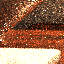

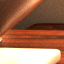

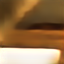

Epoch 2/10000
464/688 [===================>..........] - ETA: 12s - loss: 6.9887 - mean_absolute_error: 6.9887

KeyboardInterrupt: 

In [30]:
print("Fit model on training data")
image_cb = DisplayImageCallback()
history_cb = tf.keras.callbacks.CSVLogger('./training_2/log.csv', separator=",", append=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(
    train,
    validation_data=validate,
    epochs=10000,
    callbacks=[cp_callback, history_cb, image_cb]
)

In [12]:
# print(model.layers[1].get_weights()[0])
# model.predict(xpatch)

In [ ]:
newpatch = x_patches[1350] #np.reshape(x_patches[1350], (1, 64, 64, 40))
newpatch = np.stack((newpatch, newpatch, newpatch, newpatch, newpatch), axis=0)
newpatch.shape

In [13]:
pn = 405
xpatch = x_patches[pn]
xpatch = np.stack((xpatch, xpatch, xpatch, xpatch, xpatch), axis=0)
prediction = model.predict(xpatch)
prediction
xpatch

array([[[[ 79.,  54.,  37., ..., 181.,  53., 194.],
         [ 81.,  51.,  33., ..., 182.,  52., 193.],
         [130.,  62.,  35., ..., 182.,  51., 192.],
         ...,
         [139.,  89.,  60., ..., 127., 127., 255.],
         [123.,  89.,  64., ..., 127., 127., 255.],
         [181., 128.,  91., ..., 127., 127., 255.]],

        [[ 48.,  25.,  14., ..., 176.,  44., 187.],
         [111.,  73.,  50., ..., 177.,  44., 186.],
         [ 55.,  36.,  24., ..., 181.,  30., 189.],
         ...,
         [ 77.,  38.,  24., ..., 127., 127., 255.],
         [154., 111.,  79., ..., 127., 127., 255.],
         [148.,  84.,  51., ..., 127., 127., 255.]],

        [[115.,  80.,  56., ..., 173.,  57., 182.],
         [ 95.,  46.,  28., ..., 177.,  43., 185.],
         [ 72.,  32.,  16., ..., 160., 114., 166.],
         ...,
         [151.,  78.,  47., ..., 127., 127., 255.],
         [ 87.,  60.,  42., ..., 127., 127., 255.],
         [111.,  87.,  64., ..., 127., 127., 255.]],

        ...,

  

In [ ]:
# imshow((prediction[0] * 255.0).astype(np.uint8))
prediction